This is the script to draw distrubution plot to see bi or multi modalities for gene expression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import gaussian_kde

In [ ]:
data_path = '../Data/Cluster_Results/'

## if need to read several csv files from a folder, run the next block

In [3]:
# Get a list of all CSV files in the directory
csv_files = glob.glob(data_path + '/*.csv')

# Create an empty list to store the dataframes
dfs = []

# Iterate over each CSV file and read it into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate the dataframes into a single dataframe
combined_df = pd.concat(dfs)

df = combined_df.copy()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_37251/1727096563.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [4]:
df = df.loc[df['Autoinducer'] == 'Without']

In [5]:
df.gene.value_counts()

gene
rpsL    54970
lasB    13027
lasR    10669
lasI     9638
Name: count, dtype: int64

In [6]:
# calculate the time from the frames
df['time'] = df['frames']*0.25

# if divide by time points
selected_time_points = np.linspace(df['time'].min(), df['time'].max(), 12)

selected_time_points = np.array([min(df['time'].unique(), key=lambda x: abs(x - tp)) for tp in selected_time_points])

# # if divide by frames

# selected_time_points = np.linspace(df['frames'].min(), df['frames'].max(), 12)

# selected_time_points = selected_time_points.astype(int)

In [7]:
df_selected = df[df['time'].isin(selected_time_points)].copy()
df_selected['fluo1_pixel_intensity'] = df_selected['fluo1'] / df_selected['area']
df_selected['fluo2_pixel_intensity'] = df_selected['fluo2'] / df_selected['area']

In [8]:
average_value_1 = df_selected['fluo1_pixel_intensity'].mean()
average_value_2 = df_selected['fluo2_pixel_intensity'].mean()
print(average_value_1, average_value_2)

1.363266467262887 86.4232524368385


In [9]:
# Create a figure and axis
sns.set(style='whitegrid')

time_points = sorted(selected_time_points)

def plot_kde(df, gene, selected_time_points, y_fluo, bw, y_offset):
    
    plt.figure(figsize=(10, 8))
    
    df_gene = df[df['gene'] == gene].copy()
    time_points = sorted(selected_time_points)
    y_offsets = []
    
    
    for i, time_point in enumerate(time_points):
        subset = df_gene[df_gene['time'] == time_point]
        fluo_values = subset[y_fluo].dropna()
        
        kde = gaussian_kde(fluo_values, bw_method=bw)
        x = np.linspace(fluo_values.min(), fluo_values.max(), 1000)
        y = kde(x)
        
        offset = i * y_offset
        y_offsets.append(offset)
        plt.fill_between(x, y + offset, offset, alpha=0.5, label=f'{(time_point):.2f}h', color=sns.color_palette("viridis", len(selected_time_points))[i])
    
    # set y axis to time points, remove the current numerical ticks
    plt.yticks(y_offsets, [f'{tp:.2f}h' for tp in time_points], fontsize=14)

    # set labels and title
    plt.xlabel('Individual Cell Response', fontsize=16)
    plt.ylabel('Time Point', fontsize=16)
    plt.legend(title = 'Time', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Distribution of Individual Cell Responses Over Time: {gene}', fontsize=20)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # show the plot
    plt.show()


### plot for different genes

ValueError: `dataset` input should have multiple elements.

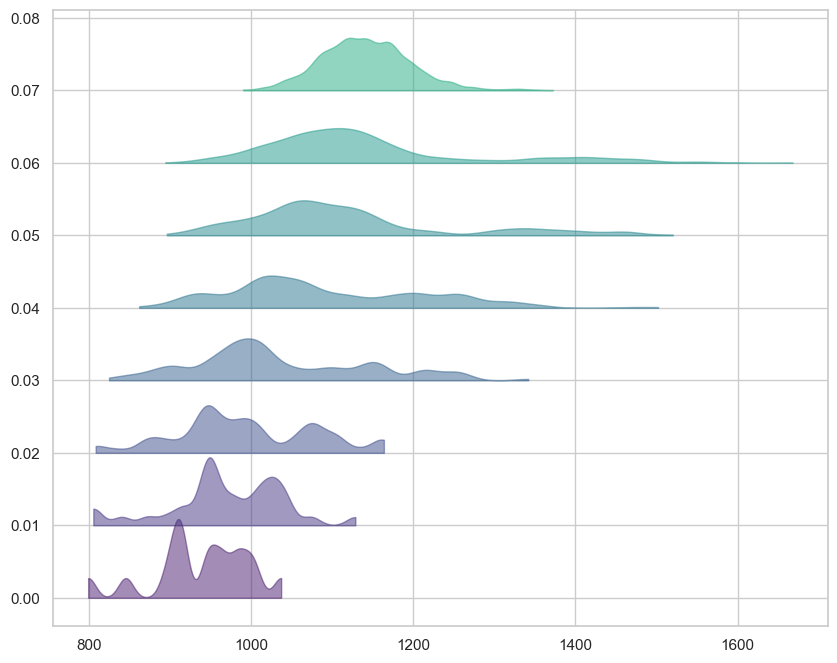

In [10]:
plot_kde(df_selected, 'lasB', selected_time_points, 'fluo2', 0.15, 0.01)

### plot for single colony

In [56]:
df_test = df.loc[df.cluster == 44].copy()
selected_time_points_new = np.linspace(df_test['time'].min(), df_test['time'].max(), 12)
selected_time_points_new = np.array([min(df_test['time'].unique(), key=lambda x: abs(x - tp)) for tp in selected_time_points_new])

In [61]:
selected_time_points_new=[1.  ,  2.25,  3.25,  4.25,  5.5 ,  6.5 ,  7.75,  8.75,
        9.75, 11.  , 12.  ]

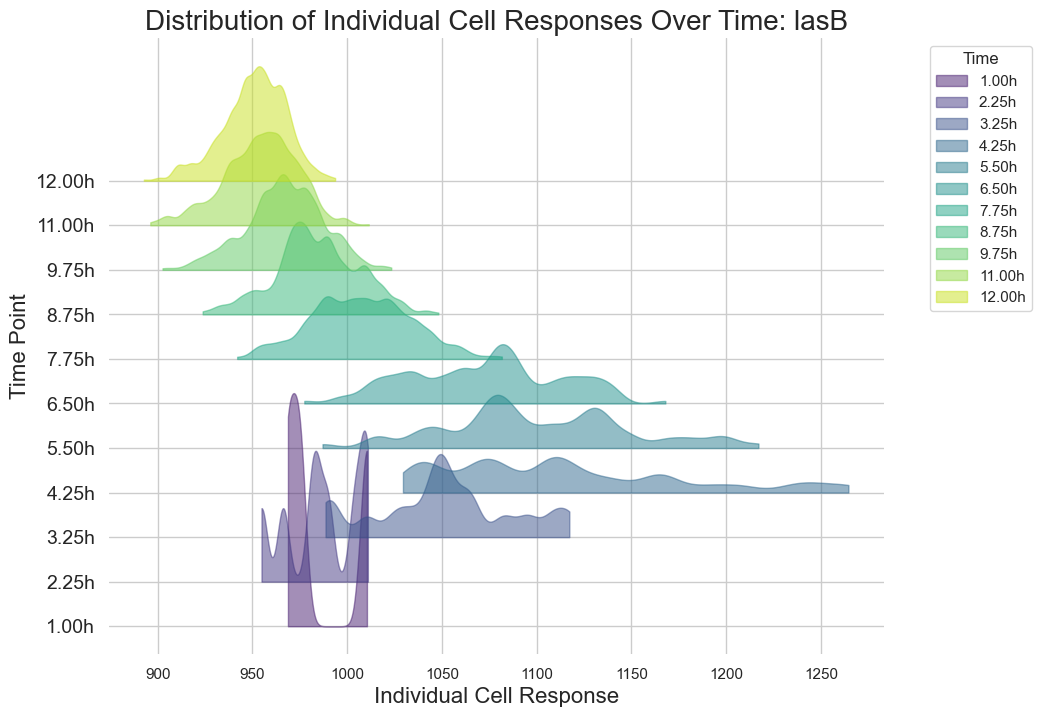

In [65]:
plot_kde(df_test, 'lasB', selected_time_points_new, 'fluo2', 0.15, 0.01)

### plot for different colony size

In [69]:
# Calculate counts while retaining fluo2
counts_df = df.groupby(['cluster', 'frames']).size().reset_index(name='counts')

# Merge the counts back into the original DataFrame
df = df.merge(counts_df, on=['cluster', 'frames'], how='left')

In [76]:
# Define the bins and labels
bins = [0, 50, 150, 250, 500, float('inf')]
labels = ['(0, 50)', '(50, 150)', '(150, 250)', '(250, 500)', '(>500)']

# Create the new column with categorized counts
df['count_category'] = pd.cut(df['counts'], bins=bins, labels=labels, right=False)


In [81]:
id = df.counts.idxmax()
df.loc[id]

Unnamed: 0             1117832
id                           1
mother                     NaN
frames                      43
daughters                  NaN
new_pole           [1311 1022]
old_pole           [1277 1008]
edges                      NaN
length               48.459824
width                 8.567483
area                     309.0
perimeter                   64
fluo1                111.19888
fluo2               964.207283
x                       1294.0
y                       1015.0
IntDen            34360.453782
series                      19
Autoinducer               With
gene                      lasB
new_y                   1010.0
new_x                   1015.0
Group                        1
cluster                   52.0
normalized_GFP        8.671016
time                     10.75
counts                  1096.0
count_category          (>500)
Name: 38773, dtype: object

In [82]:
# Create a figure and axis
sns.set(style='whitegrid')

# time_points = sorted(selected_time_points)

def plot_kde(df, gene, selected_category, y_fluo, bw, y_offset):
    
    plt.figure(figsize=(10, 8))
    
    df_gene = df[df['gene'] == gene].copy()
    y_offsets = []
    
    
    for i, category in enumerate(selected_category):
        subset = df_gene[df_gene['count_category'] == category]
        fluo_values = subset[y_fluo].dropna()
        
        kde = gaussian_kde(fluo_values, bw_method=bw)
        x = np.linspace(fluo_values.min(), fluo_values.max(), 1000)
        y = kde(x)
        
        offset = i * y_offset
        y_offsets.append(offset)
        plt.fill_between(x, y + offset, offset, alpha=0.5, label=category, color=sns.color_palette("viridis", len(selected_category))[i])
    
    # set y axis to time points, remove the current numerical ticks
    plt.yticks(y_offsets, [ct for ct in selected_category], fontsize=14)

    # set labels and title
    plt.xlabel('Individual Cell Response', fontsize=16)
    plt.ylabel('colony size', fontsize=16)
    plt.legend(title = 'colony size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Distribution of Individual Cell Responses Over Time: {gene}', fontsize=20)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # show the plot
    plt.show()

In [ ]:
df.loc[df.gene=='lasR']['count_category'].value_counts()

count_category
(50, 150)     12926
(250, 500)     9920
(150, 250)     9203
(0, 50)        7303
(>500)            0
Name: count, dtype: int64

In [87]:
labels_1 = ['(0, 50)', '(50, 150)', '(150, 250)', '(250, 500)']

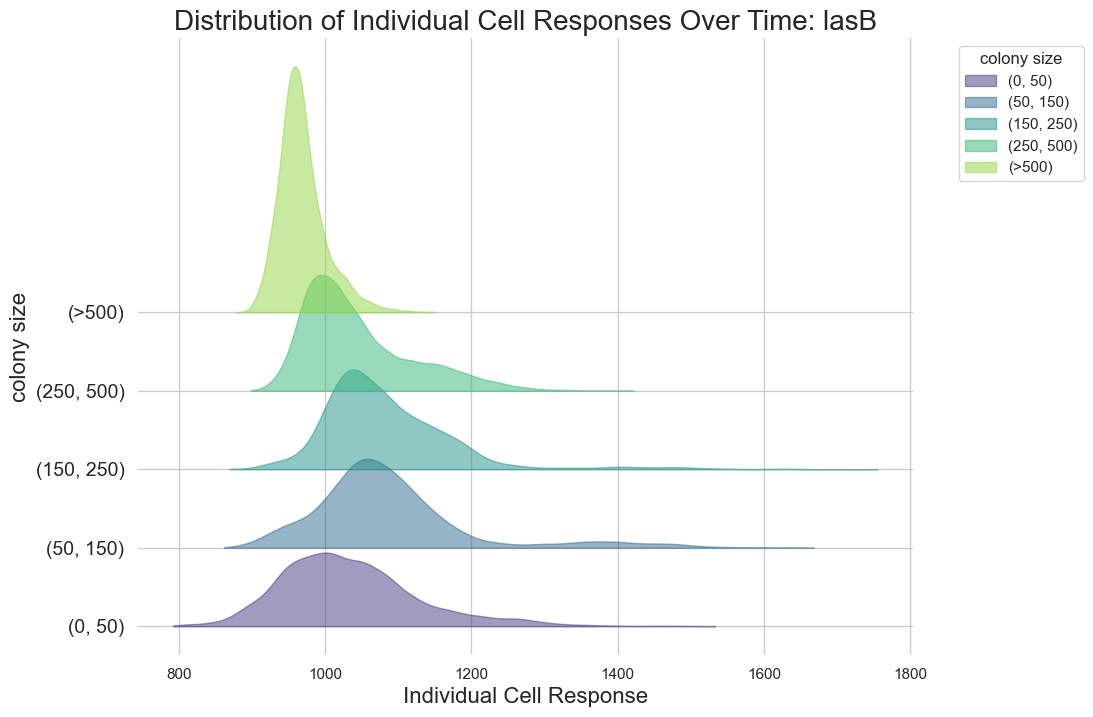

In [91]:
plot_kde(df, 'lasB', labels, 'fluo2', 0.15, 0.005)

### Draw Density Plot for different genes

In [21]:
df_sub = df[(df['time'] == 6) & (df['gene']!='rpsL')].copy()
df_sub['nGFP'] = df_sub['fluo2'] / df_sub['fluo1']

# Define custom colors for each gene
custom_palette = {'lasB': sns.color_palette("colorblind")[0], 
                  'lasI': sns.color_palette("colorblind")[1], 
                  'lasR': sns.color_palette("colorblind")[2],
                  'rpsL': sns.color_palette("colorblind")[3]}

gene_order = ['lasI', 'lasR', 'lasB']
df_sub['gene'] = pd.Categorical(df_sub['gene'], categories=gene_order, ordered=True)

# 按 gene 进行第一层分组
grouped_by_gene = df_sub.groupby('gene')

y_tick = []
# 遍历每个基因分组
for gene_name, group in grouped_by_gene:
    # 对该基因的分组数据按 cluster 进行第二层分组，并统计 id 的数量
    cluster_counts = group.groupby('cluster')['id'].count().reset_index()
    
    # 保存 gene, min, 和 max 信息到字典中
    y_tick.append({
        'gene': gene_name,
        'min': cluster_counts['id'].min(),
        'max': cluster_counts['id'].max()
    })
    
    # 打印结果
    print(f"Gene: {gene_name}")
    print(cluster_counts)

# 将 y_tick 转换为 DataFrame
y_tick_df = pd.DataFrame(y_tick)

# 生成 y_tick_label，格式为 "gene (min, max)"
y_tick_label = [f"{row['gene']} ({row['min']}, {row['max']})" for _, row in y_tick_df.iterrows()]

# 打印最终结果
print("\ny_tick_label:")
print(y_tick_label)

# Create a figure and axis
sns.set(style='whitegrid')

# time_points = sorted(selected_time_points)

def plot_kde(df, y_fluo, bw, y_offset):
    
    plt.figure(figsize=(10, 8))
    
    y_offsets = []
    
    for i, gene in enumerate(gene_order):
        if gene == 'rpsL':
            continue
        else:
            subset = df[df['gene'] == gene]
            fluo_values = subset[y_fluo].dropna()
            
            kde = gaussian_kde(fluo_values, bw_method=bw)
            x = np.linspace(fluo_values.min(), fluo_values.max(), 1000)
            y = kde(x)
            
            offset = i * y_offset
            y_offsets.append(offset)
            plt.fill_between(x, y + offset, offset, alpha=0.5, label=gene, color=custom_palette[gene])
            plt.xlim(0, 12)
    
    # set y axis to time points, remove the current numerical ticks
    plt.yticks(y_offsets, [ct for ct in y_tick_label], fontsize=16)

    # set labels and title
    plt.xlabel('Individual Cell Response', fontsize=24)
    plt.ylabel('Gene (Colony Size)', fontsize=24)
    # plt.legend(title = 'colony size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Distribution of Individual Cell Responses at 6 hours', fontsize=24)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # show the plot
    plt.show()

Gene: lasI
   cluster   id
0     78.0  107
1     79.0   73
2     80.0   62
3     81.0   94
4     82.0   65
5     83.0  113
6     84.0  121
7     85.0   78
8     86.0   58
9     87.0   61
Gene: lasR
   cluster   id
0     59.0   71
1     61.0  109
2     62.0   62
3     63.0   72
4     64.0   81
5     65.0  117
Gene: lasB
   cluster   id
0     88.0   69
1     89.0   91
2     90.0   96
3     91.0   53
4     92.0  106
5     93.0   60
6     94.0   86
7     95.0  106

y_tick_label:
['lasI (58, 121)', 'lasR (62, 117)', 'lasB (53, 106)']


/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_37251/457496616.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_gene = df_sub.groupby('gene')


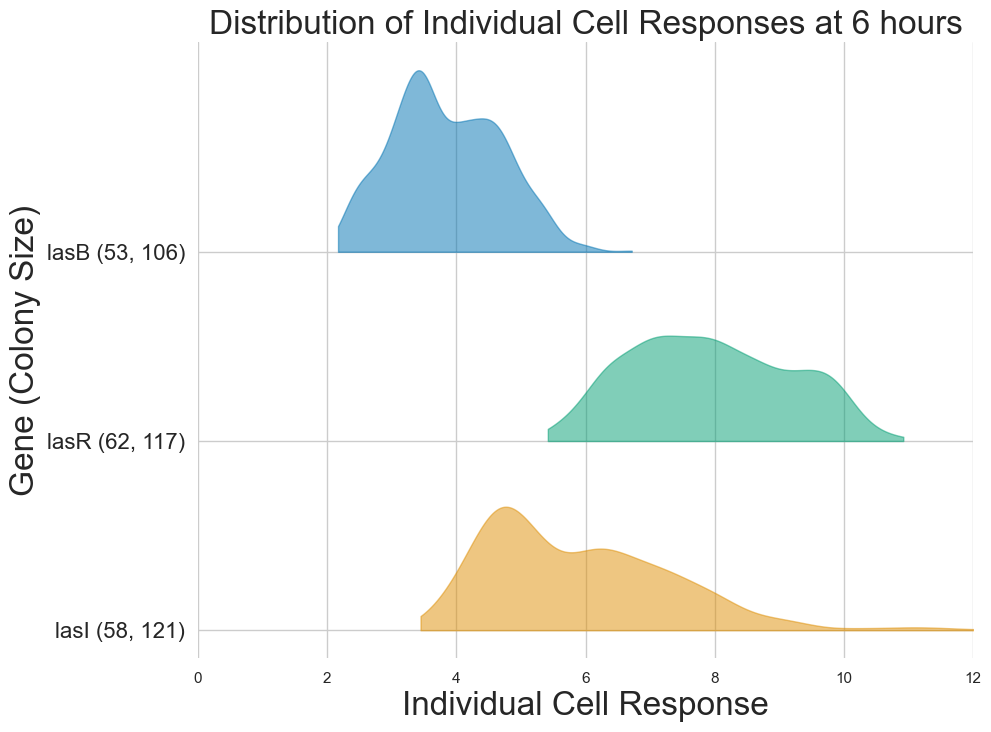

In [22]:
plot_kde(df_sub,'nGFP', 0.25, 0.5)